In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [28]:
# Load data
df = pd.read_csv('../data/raw/heart.csv')
print(f"Original dataset shape: {df.shape}")

# Remove duplicates
df_clean = df.drop_duplicates()
print(f"After removing duplicates: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} duplicate rows")

df=df_clean

# Separate features and target
X = df_clean.drop('target', axis=1)
y = df_clean['target']

print(f"\nFeatures: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Original dataset shape: (1025, 14)
After removing duplicates: (302, 14)
Removed 723 duplicate rows

Features: (302, 13)
Target distribution:
target
1    164
0    138
Name: count, dtype: int64


In [29]:
# Check for duplicates
print(f"Total rows: {len(df)}")
print(f"Unique rows: {df.drop_duplicates().shape[0]}")
print(f"Duplicates: {len(df) - df.drop_duplicates().shape[0]}")

# Show some duplicates
duplicates = df[df.duplicated(keep=False)]
print(f"\nDuplicated entries: {len(duplicates)}")

Total rows: 302
Unique rows: 302
Duplicates: 0

Duplicated entries: 0


In [30]:
#df = pd.read_csv('../data/raw/heart.csv')
print(f"Dataset shape: {df.shape}")

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

print(f"Features: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Dataset shape: (302, 14)
Features: (302, 13)
Target distribution:
target
1    164
0    138
Name: count, dtype: int64


In [31]:
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain target distribution:\n{y_train.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")

Train set: (241, 13)
Test set: (61, 13)

Train target distribution:
target
1    131
0    110
Name: count, dtype: int64
Test target distribution:
target
1    33
0    28
Name: count, dtype: int64


In [32]:
# Scale features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully")
print(f"Train mean: {X_train_scaled.mean():.2f}")
print(f"Train std: {X_train_scaled.std():.2f}")

Features scaled successfully
Train mean: -0.00
Train std: 1.00


In [33]:
# Train logistic regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Logistic Regression Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_lr):.3f}")

Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        28
           1       0.80      0.85      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61


ROC-AUC Score: 0.871


In [34]:
# Train random forest (no scaling needed)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("Random Forest Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_rf):.3f}")

Random Forest Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.71      0.73        28
           1       0.76      0.79      0.78        33

    accuracy                           0.75        61
   macro avg       0.75      0.75      0.75        61
weighted avg       0.75      0.75      0.75        61


ROC-AUC Score: 0.861


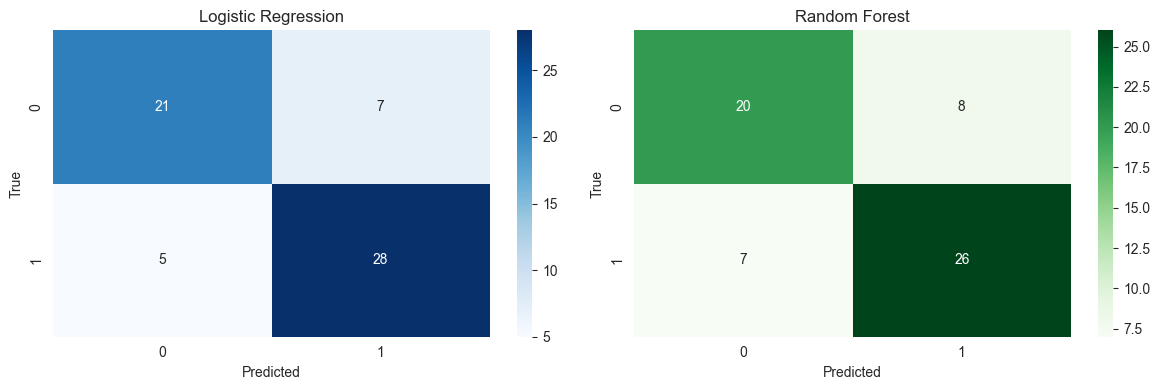

In [35]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

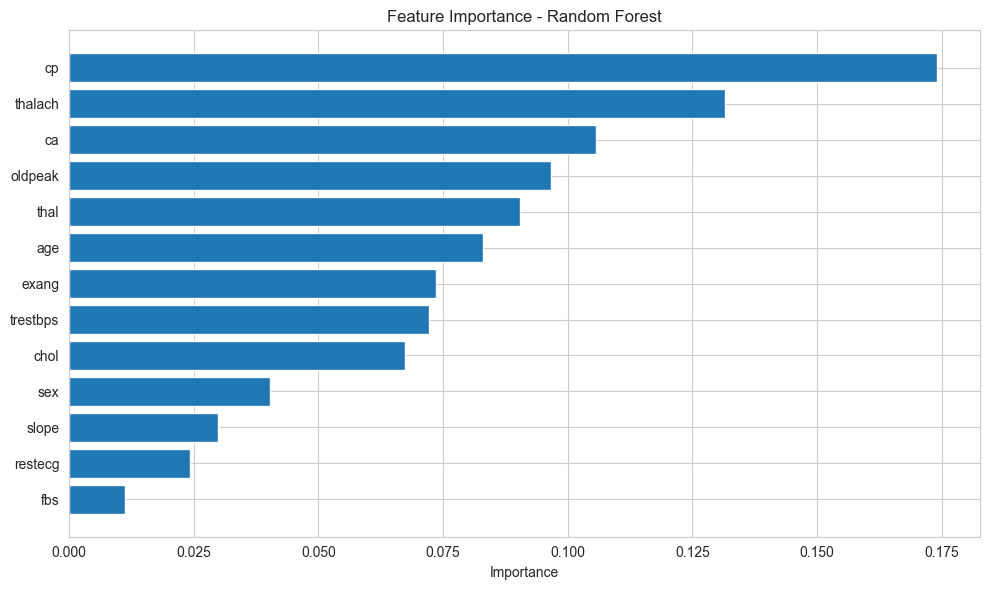


Top 5 most important features:
    feature  importance
2        cp    0.173969
7   thalach    0.131634
11       ca    0.105700
9   oldpeak    0.096577
12     thal    0.090418


In [37]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(feature_importance.head())

In [38]:
# Cell 9 - Summary
print("="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"Logistic Regression: {roc_auc_score(y_test, y_proba_lr):.3f} ROC-AUC")
print(f"Random Forest:       {roc_auc_score(y_test, y_proba_rf):.3f} ROC-AUC")
print(f"\nBest model: Logistic Regression")
print(f"Test accuracy: {(y_pred_lr == y_test).mean():.2%}")

MODEL COMPARISON SUMMARY
Logistic Regression: 0.871 ROC-AUC
Random Forest:       0.861 ROC-AUC

Best model: Logistic Regression
Test accuracy: 80.33%


In [41]:
# Train XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluate
print("XGBoost Results:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_xgb):.3f}")

XGBoost Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        28
           1       0.74      0.76      0.75        33

    accuracy                           0.72        61
   macro avg       0.72      0.72      0.72        61
weighted avg       0.72      0.72      0.72        61


ROC-AUC Score: 0.832


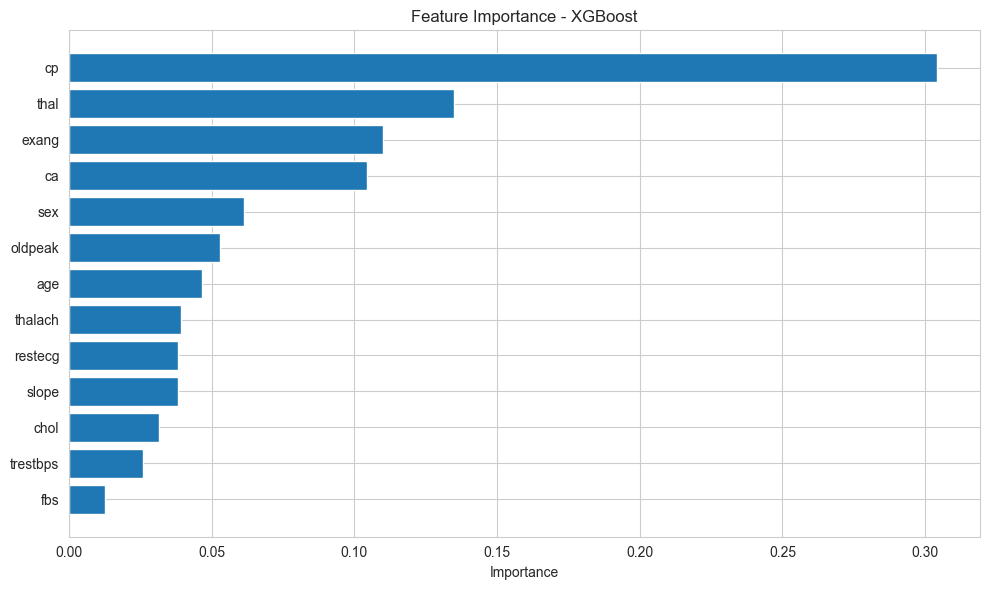


Top 5 most important features (XGBoost):
   feature  importance
2       cp    0.304015
12    thal    0.135067
8    exang    0.110176
11      ca    0.104592
1      sex    0.061322


In [42]:
# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(xgb_importance['feature'], xgb_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 most important features (XGBoost):")
print(xgb_importance.head())

In [43]:
# Model comparison
print("="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
models = {
    'Logistic Regression': (roc_auc_score(y_test, y_proba_lr), (y_pred_lr == y_test).mean()),
    'Random Forest': (roc_auc_score(y_test, y_proba_rf), (y_pred_rf == y_test).mean()),
    'XGBoost': (roc_auc_score(y_test, y_proba_xgb), (y_pred_xgb == y_test).mean())
}

for name, (auc, acc) in models.items():
    print(f"{name:20s} | ROC-AUC: {auc:.3f} | Accuracy: {acc:.2%}")

print("="*60)
best_model = max(models.items(), key=lambda x: x[1][0])
print(f"Best model: {best_model[0]} (ROC-AUC: {best_model[1][0]:.3f})")

FINAL MODEL COMPARISON
Logistic Regression  | ROC-AUC: 0.871 | Accuracy: 80.33%
Random Forest        | ROC-AUC: 0.861 | Accuracy: 75.41%
XGBoost              | ROC-AUC: 0.832 | Accuracy: 72.13%
Best model: Logistic Regression (ROC-AUC: 0.871)
